In [270]:

# useful discussion of correlations and significance of them:
# http://www.statsoft.com/Textbook/Basic-Statistics#Correlations
#   Note that correlations are not additive, ie. can't take a mean of 
#     correlations. Have to square first, then take mean. @@

import cccmaplots as cplt
import cccmautils as cutl
import cccmaNC as cnc
import constants as con
import cccmacmaps as ccm
import copy as copy
%matplotlib inline

con = reload(con)
cutl = reload(cutl)

model = 'CanAM4'
bp=con.get_basepath()
basepath=bp['basepath'] + model + '/'; subdir=bp['subdir']

field='st'  # sicn, st, pmsl, gz
level=50000
latlim=40 # start with 40N
ylims=(0,1)
ncfield=field.upper()
fieldstr=field
conv=1

    
# baseline pattern to compare to
cmpcasenamep='kem1pert2ens' # else, 'kemhadpert', 'kemnsidcpert'
cmpcasenamec='kemctl1ens'
cmptype = 'ensavg' 

#cmpcasenamep='kem1pert2' # else, 'kemhadpert', 'kemnsidcpert'
#cmpcasenamec='kemctl1'
#cmptype = 'meanBC'


bcasenamep='kem1pert2'
bcasenamec='kemctl1'

timesel = '0002-01-01,0121-12-31'
seasons = ('SON','DJF','MAM','JJA')


if field=='pmsl':
    ylims=(-1,1)
elif field=='gz':
    ylims=(-1,1)
    ncfield='PHI'
    conv=1/con.get_g()

if field in ('gz','t','u','v','q'): # only 'gz' is implemented here officially @@
    fieldstr=field+str(level/100) # for figure names
    field=field+str(level) # for filename
    

# get baseline to which to compare
fnamecc = basepath + cmpcasenamec + subdir + cmpcasenamec + '_' + field + '_001-121_ts.nc'
fnamepc = basepath + cmpcasenamep + subdir + cmpcasenamep + '_' + field + '_001-121_ts.nc'
fldcc = cnc.getNCvar(fnamecc,ncfield,timesel=timesel)*conv
fldpc = cnc.getNCvar(fnamepc,ncfield,timesel=timesel)*conv
flddc = fldpc-fldcc

lat = cnc.getNCvar(fnamecc,'lat')
lon = cnc.getNCvar(fnamecc,'lon')


# seasonal baseline to which to compare
fldccsea = np.zeros((4,len(lat),len(lon)))
fldpcsea = np.zeros((4,len(lat),len(lon)))
flddcsea = np.zeros((4,len(lat),len(lon)))
              
for seaii,sea in enumerate(seasons):
    fldccsea[seaii,...] = np.mean(cnc.getNCvar(fnamecc,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
    fldpcsea[seaii,...] = np.mean(cnc.getNCvar(fnamepc,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
    flddcsea[seaii,...] = fldpcsea[seaii,...]-fldccsea[seaii,...]


ensnum=5
diffdict = {} # fldp-fldc 
pcmeandict = {} # fldp-fldc pattern corr compared to mean BC
pchaddict = {} # fldp-fldc pattern corr compared to hadisst
seadiffdict = {} # same as above but seasonal mean
pcseameandict = {}
pcsea2meandict = {}
pcsea2pvalmeandict = {}

# generate weights for the pattern corr
areas = cutl.calc_cellareas(lat,lon)
areas = areas[lat>latlim,:]
weights = areas / np.sum(np.sum(areas,axis=1),axis=0)

for eii in range(1,ensnum+1):
    
    skey = 'r' + str(eii)
    casenamec = bcasenamec + skey
    casenamep = bcasenamep + skey
    fnamec = basepath + casenamec+ subdir + casenamec + '_' + field + '_001-121_ts.nc'
    fnamep = basepath + casenamep+ subdir + casenamep + '_' + field + '_001-121_ts.nc'

    # monthly calc
    fldc = cnc.getNCvar(fnamec,ncfield,timesel=timesel)*conv
    fldp = cnc.getNCvar(fnamep,ncfield,timesel=timesel)*conv
    fldd = fldp-fldc
    
    # take the pattern correlation
    flddclimo,flddstd = cutl.climatologize(fldd) # climo first (don't need to do for BCs technically)
    flddcclimo,flddcstd = cutl.climatologize(flddc) # climo first
    
    diffdict[skey] = flddclimo
    
    # for each month, compute pattern corr
    pc = np.zeros((12))
    for mii,mon in enumerate(con.get_mon()):
        tmp = np.squeeze(flddclimo[mii,lat>latlim,...])
        tmpcmp = np.squeeze(flddcclimo[mii,lat>latlim,...])
        pc[mii] = cutl.pattcorr(tmp.flatten()*weights.flatten(),tmpcmp.flatten()*weights.flatten())
    
    pcmeandict[skey] = pc
    
    # seasonal calc    
    fldcsea = np.zeros((4,len(lat),len(lon)))
    fldpsea = np.zeros((4,len(lat),len(lon)))
    flddsea = np.zeros((4,len(lat),len(lon)))
    for seaii,sea in enumerate(seasons):
        fldcsea[seaii,...] = np.mean(cnc.getNCvar(fnamec,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
        fldpsea[seaii,...] = np.mean(cnc.getNCvar(fnamep,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
        flddsea[seaii,...] = fldpsea[seaii,...]-fldcsea[seaii,...]
        
    
    seadiffdict[skey] = flddsea
    
    pcsea = np.zeros((4))
    pcsea2 = np.zeros((4)) # test pattcorr_pearson() @@
    pcsea2pval = np.zeros((4)) # test pattcorr_pearson()
    for seaii,sea in enumerate(seasons):
        tmp = np.squeeze(flddsea[seaii,lat>latlim,...])
        tmpcmp = np.squeeze(flddcsea[seaii,lat>latlim,...])
        pcsea[seaii] = cutl.pattcorr(tmp.flatten()*weights.flatten(),
                                     tmpcmp.flatten()*weights.flatten())
        pcsea2[seaii],pcsea2pval[seaii] = cutl.pattcorr_pearson(tmp.flatten()*weights.flatten(),
                                                                tmpcmp.flatten()*weights.flatten())
        
        
    pcseameandict[skey] = pcsea
    pcsea2meandict[skey] = pcsea2
    pcsea2pvalmeandict[skey] = pcsea2pval

colordict = ccm.get_colordict()

In [271]:
import pandas as pd

pcmeandf = pd.DataFrame(pcmeandict)
ensmax = pcmeandf.max(axis=1)
ensmin = pcmeandf.min(axis=1)
ensrng = ensmax-ensmin
ensmean = pcmeandf.mean(axis=1)
# for the purposes of calculating the internal var
#   probably need to take average of the absolute value of corr
pcmeandfabs = np.abs(pcmeandf)
ensmeanabs = pcmeandfabs.mean(axis=1)

pcmeandfinv = 1 - np.abs(pcmeandf)
ensmaxi = pcmeandfinv.max(axis=1)
ensmini = pcmeandfinv.min(axis=1)
ensrngi = ensmaxi-ensmini
ensmeani = pcmeandfinv.mean(axis=1)


# seasonal version ============================
pcseameandf = pd.DataFrame(pcseameandict)
ensmaxsea = pcseameandf.max(axis=1)
ensminsea = pcseameandf.min(axis=1)
ensrngsea = ensmaxsea-ensminsea
ensmeansea = pcseameandf.mean(axis=1)
# for the purposes of calculating the internal var
#   probably need to take average of the absolute value of corr
pcseameandfabs = np.abs(pcseameandf)
ensmeanabssea = pcseameandfabs.mean(axis=1)

#     test second version of pattcorr
#     where the pearsonr() function is called. gives same answer
pcsea2meandf = pd.DataFrame(pcsea2meandict)
ensmeansea2 = pcsea2meandf.mean(axis=1)

pcsea2pvalmeandf = pd.DataFrame(pcsea2pvalmeandict)
ensmeansea2pval = pcsea2pvalmeandf.mean(axis=1)

print pcsea2meandf
print pcsea2pvalmeandf

print ensmeansea
print ensmeansea2
print ensmeansea2pval

print areas.shape

         r1        r2        r3        r4        r5
0  0.966434  0.935948  0.905632  0.954862  0.933126
1  0.888004  0.903748  0.906845  0.758036  0.820627
2  0.836426  0.812952  0.818690  0.655536  0.618789
3  0.754045  0.562844  0.645898  0.675564  0.705786

[4 rows x 5 columns]
   r1             r2             r3             r4             r5
0   0   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00
1   0   0.000000e+00   0.000000e+00   0.000000e+00   0.000000e+00
2   0   0.000000e+00   0.000000e+00  2.867515e-285  1.737587e-245
3   0  3.541364e-194  2.659195e-274  2.116082e-309   0.000000e+00

[4 rows x 5 columns]
0    0.939200
1    0.855452
2    0.748479
3    0.668827
dtype: float64
0    0.939200
1    0.855452
2    0.748479
3    0.668827
dtype: float64
0     0.000000e+00
1     0.000000e+00
2    3.475174e-246
3    7.082728e-195
dtype: float64
(18, 129)


In [272]:
# trying to figure out what minimum r-value (correlation) is significant
# given sample size, N
# Tried plugging 1290 into online calc to see when t > 1.9719 and r was 
#  about 0.055 (tiny, as expected). http://vassarstats.net/textbook/ch4apx.html
#  which matches my own calc below.

# @@ function in classes/cccmautils now!
N=np.squeeze(areas.flatten().shape)

print N
tcrit = 1.9719 # 0.05

denom = ((N-2)/np.power(tcrit,2)) + 1
rmin = np.sqrt( 1/denom)

print rmin

# So for sample sizes of 1200+ points, basically all correlations are significant. 
# Thus, no need to shade the figure?

2322
0.0409050807108


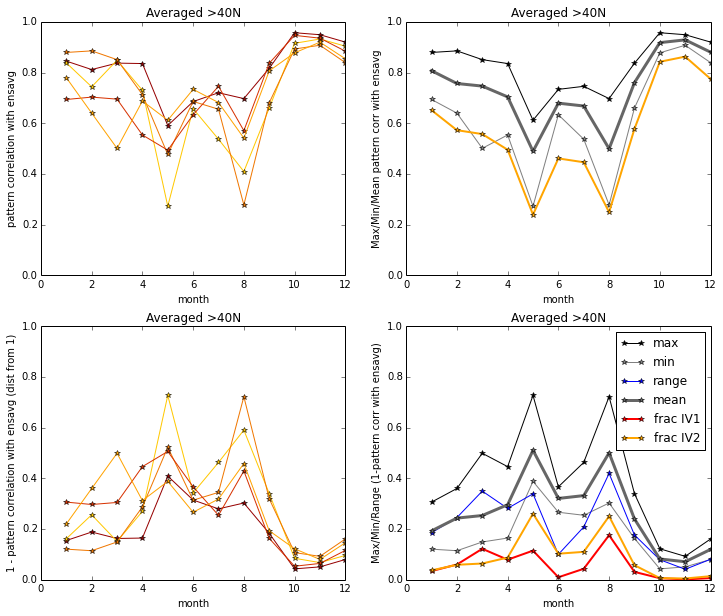

In [273]:
printtofile=False

xx=np.arange(1,13)

fig,axs = plt.subplots(2,2)
fig.set_size_inches(12,10)
ax = axs[0,0]
for eii in range(1,ensnum+1):
    
    skey = 'r' + str(eii)
    ax.plot(xx,pcmeandict[skey],color=colordict[skey],marker='*')
    
ax.set_ylabel('pattern correlation with ' + cmptype)
ax.set_xlabel('month')
ax.set_title('Averaged >' + str(latlim) + 'N')
ax.set_ylim(ylims)

ax = axs[1,0]
for eii in range(1,ensnum+1):
    
    skey = 'r' + str(eii)
    ax.plot(xx,1-np.abs(pcmeandict[skey]),color=colordict[skey],marker='*')
    
ax.set_ylabel('1 - pattern correlation with ' + cmptype + ' (dist from 1)')
ax.set_xlabel('month')
ax.set_title('Averaged >' + str(latlim) + 'N')
ax.set_ylim((0,1))

# now want to plot the range
ax = axs[0,1]

ax.plot(xx,ensmax,color='k',marker='*')
ax.plot(xx,ensmin,color='0.5',marker='*')
#ax.plot(xx,ensrng,color='b',marker='*')
ax.plot(xx,ensmean,color='.4',marker='*',linewidth=3)
ax.plot(xx,ensmeanabs*ensmeanabs,color='orange',marker='*',linewidth=2)


ax.set_ylabel('Max/Min/Mean pattern corr with ' + cmptype)
ax.set_xlabel('month')
ax.set_title('Averaged >' + str(latlim) + 'N')
ax.set_ylim(ylims)

# now want to plot the range
ax = axs[1,1]

ax.plot(xx,ensmaxi,color='k',marker='*')
ax.plot(xx,ensmini,color='0.5',marker='*')
ax.plot(xx,ensrngi,color='b',marker='*')
ax.plot(xx,ensmeani,color='.4',marker='*',linewidth=3)

ax.plot(xx,ensrngi*ensrngi,color='r',marker='*',linewidth=2)
ax.plot(xx,ensmeani*ensmeani,color='orange',marker='*',linewidth=2)


ax.set_ylabel('Max/Min/Range (1-pattern corr with ' + cmptype + ')')
ax.set_xlabel('month')
ax.set_title('Averaged >' + str(latlim) + 'N')
ax.set_ylim((0,1))
ax.legend(('max','min','range','mean','frac IV1','frac IV2'))

if printtofile:
    fig.savefig(fieldstr + 'pattcorr_nof' + str(latlim) + 'N_ensmems_cmpto_' + cmptype + '_seacyc.pdf')

In [274]:
#print ensrngi*ensrngi*100 # same for ensrng*ensrng
print ensmeani*ensmeani*100

print ensmean*ensmean*100

print ensmeanabs*ensmeanabs*100

print 'SEASONAL:'
print ensmeansea*ensmeansea*100
print ensmeanabssea*ensmeanabssea*100


0      3.718547
1      5.916589
2      6.424455
3      8.763401
4     26.067406
5     10.291313
6     11.020286
7     25.053529
8      5.753828
9      0.675221
10     0.507304
11     1.432247
dtype: float64
0     65.151477
1     57.268511
2     55.731438
3     49.557316
4     23.954908
5     46.131160
6     44.626654
7     24.946528
8     57.779551
9     84.240859
10    86.262254
11    77.496942
dtype: float64
0     65.151477
1     57.268511
2     55.731438
3     49.557316
4     23.954908
5     46.131160
6     44.626654
7     24.946528
8     57.779551
9     84.240859
10    86.262254
11    77.496942
dtype: float64
SEASONAL:
0    88.209719
1    73.179801
2    56.022040
3    44.733011
dtype: float64
0    88.209719
1    73.179801
2    56.022040
3    44.733011
dtype: float64


In [275]:
# Calculate again for latlim>60N
#  Here the '2' suffix means latlim>60. (this is confusing...)

latlim=60

ensnum=5
diffdict = {} # fldp-fldc 
pcmeandict2 = {} # fldp-fldc pattern corr compared to mean BC
pchaddict2 = {} # fldp-fldc pattern corr compared to hadisst
seadiffdict = {}
pcseameandict2 = {}

# generate weights for the pattern corr
areas = cutl.calc_cellareas(lat,lon)
areas = areas[lat>latlim,:]
weights2 = areas / np.sum(np.sum(areas,axis=1),axis=0)


for eii in range(1,ensnum+1):
    
    skey = 'r' + str(eii)
    casenamec = bcasenamec + skey
    casenamep = bcasenamep + skey
    fnamec = basepath + casenamec+ subdir + casenamec + '_' + field + '_001-121_ts.nc'
    fnamep = basepath + casenamep+ subdir + casenamep + '_' + field + '_001-121_ts.nc'

    fldc = cnc.getNCvar(fnamec,ncfield,timesel=timesel)*conv
    fldp = cnc.getNCvar(fnamep,ncfield,timesel=timesel)*conv
    fldd = fldp-fldc
    
    # take the pattern correlation
    flddclimo,flddstd = cutl.climatologize(fldd) # climo first (don't need to do for BCs technically)
    flddcclimo,flddcstd = cutl.climatologize(flddc) # climo first
    
    
    diffdict[skey] = flddclimo
    
    # for each month, compute pattern corr
    pc = np.zeros((12))
    for mii,mon in enumerate(con.get_mon()):
        tmp = np.squeeze(flddclimo[mii,lat>latlim,...])
        tmpcmp = np.squeeze(flddcclimo[mii,lat>latlim,...])
        pc[mii] = cutl.pattcorr(tmp.flatten()*weights2.flatten(),tmpcmp.flatten()*weights2.flatten())
    
    pcmeandict2[skey] = pc
    
    
    # seasonal calc  ==========================  
    fldcsea = np.zeros((4,len(lat),len(lon)))
    fldpsea = np.zeros((4,len(lat),len(lon)))
    flddsea = np.zeros((4,len(lat),len(lon)))
    pcsea = np.zeros((4))
    for seaii,sea in enumerate(seasons):
        fldcsea[seaii,...] = np.mean(cnc.getNCvar(fnamec,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
        fldpsea[seaii,...] = np.mean(cnc.getNCvar(fnamep,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
        flddsea[seaii,...] = fldpsea[seaii,...]-fldcsea[seaii,...]
        
        tmp = np.squeeze(flddsea[seaii,lat>latlim,...])
        tmpcmp = np.squeeze(flddcsea[seaii,lat>latlim,...])
        pcsea[seaii] = cutl.pattcorr(tmp.flatten()*weights2.flatten(),tmpcmp.flatten()*weights2.flatten())
    
    seadiffdict[skey] = flddsea
    
    #pcsea = np.zeros((4))
    #for seaii,sea in enumerate(seasons):
    #    tmp = np.squeeze(flddsea[seaii,lat>latlim,...])
    #    tmpcmp = np.squeeze(flddcsea[seaii,lat>latlim,...])
    #    pcsea[seaii] = cutl.pattcorr(tmp.flatten()*weights2.flatten(),tmpcmp.flatten()*weights2.flatten())
        
    pcseameandict2[skey] = pcsea


# the '2' suffix is for the latlim>60 set of calcs

pcmeandf2 = pd.DataFrame(pcmeandict2)
ensmax2 = pcmeandf2.max(axis=1)
ensmin2 = pcmeandf2.min(axis=1)
ensrng2 = ensmax2-ensmin2
ensmean2 = pcmeandf2.mean(axis=1)
# Maybe aren't supposed to average correlations?
#   see: http://www.statsoft.com/Textbook/Statistics-Glossary/P/button/p#Pearson%20Correlation
# Instead, square first, then average
pcmeandf2sq = np.power(pcmeandf2,2)
ensmean2sq = pcmeandf2sq.mean(axis=1)

# for the purposes of calculating the internal var
#   probably need to take average of the absolute value of corr @@ No, decided against.
pcmeandf2abs = np.abs(pcmeandf2)
ensmean2abs = pcmeandf2abs.mean(axis=1)

# inverse...not using...
pcmeandfinv2 = 1 - np.abs(pcmeandf2)
ensmaxi2 = pcmeandfinv2.max(axis=1)
ensmini2 = pcmeandfinv2.min(axis=1)
ensrngi2 = ensmaxi2-ensmini2
ensmeani2 = pcmeandfinv2.mean(axis=1)


# seasonal version
pcseameandf2 = pd.DataFrame(pcseameandict2)
ensmaxsea2 = pcseameandf2.max(axis=1)
ensminsea2 = pcseameandf2.min(axis=1)
ensrngsea2 = ensmaxsea2-ensminsea2
ensmeansea2 = pcseameandf2.mean(axis=1)
# for the purposes of calculating the internal var
#   probably need to take average of the absolute value of corr
pcseameandfabs2 = np.abs(pcseameandf2)
ensmeanabssea2 = pcseameandfabs2.mean(axis=1)

# Maybe aren't supposed to average correlations?
#   see: http://www.statsoft.com/Textbook/Statistics-Glossary/P/button/p#Pearson%20Correlation
# Instead, square first, then average
# For correlations below zero, should set to zero before squaring b/c shouldn't count in mean (%var)
testpcseameandf2=copy.deepcopy(pcseameandf2)
testpcseameandf2[pcseameandf2<0] = 0
pcseameandf2sq = np.power(testpcseameandf2,2) # square the pattern corrs (the ones that are positive)
ensmeansea2sq = pcseameandf2sq.mean(axis=1) # take the average, squared patt corr (coefficient of determination)
print '------ ' + fieldstr + ' All the correlations: '
print pcseameandf2
print 'Corr with ' + cmptype + ' -- All the coefs of determination: '
print pcseameandf2sq
print 'Avg coef of determination: ' 
print ensmeansea2sq

------ st All the correlations: 
         r1        r2        r3        r4        r5
0  0.957566  0.930458  0.886297  0.948305  0.927489
1  0.896803  0.919940  0.874058  0.716130  0.850975
2  0.773389  0.761717  0.752536  0.554731  0.696181
3  0.776146  0.611456  0.573653  0.681032  0.637297

[4 rows x 5 columns]
Corr with ensavg -- All the coefs of determination: 
         r1        r2        r3        r4        r5
0  0.916932  0.865752  0.785522  0.899282  0.860236
1  0.804255  0.846289  0.763977  0.512842  0.724158
2  0.598131  0.580213  0.566311  0.307726  0.484669
3  0.602402  0.373879  0.329077  0.463804  0.406147

[4 rows x 5 columns]
Avg coef of determination: 
0    0.865545
1    0.730304
2    0.507410
3    0.435062
dtype: float64


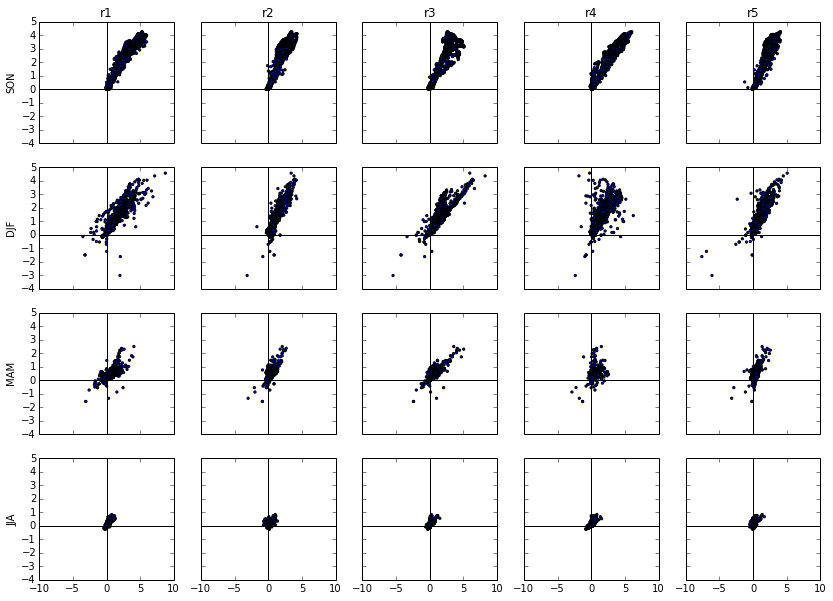

In [276]:
# scatter plot: seadiffdict (skey x sea x space) with flddcsea (sea x space)
#    make sure to only get the points > latlim
#    also area-weight? here's what the pattern corr looks like:
# 
#        tmp = np.squeeze(flddsea[seaii,lat>latlim,...])
#        tmpcmp = np.squeeze(flddcsea[seaii,lat>latlim,...])
#        pcsea[seaii] = cutl.pattcorr(tmp.flatten()*weights2.flatten(),tmpcmp.flatten()*weights2.flatten())

# @@ add regression line and r, r^2

printtofile=False

#subseasons=('SON','DJF')
subseasons=seasons
fig,axs = plt.subplots(len(subseasons),ensnum,sharey=True,sharex=True)
fig.set_size_inches(14,10)


for eii in range(1,ensnum+1):
    
    skey = 'r' + str(eii)
    
    for sii,sea in enumerate(subseasons):
        ax = axs[sii,eii-1]
        
        scatxx = seadiffdict[skey]
        scatxx = np.squeeze(scatxx[sii,lat>latlim,...])
        scatyy = np.squeeze(flddcsea[sii,lat>latlim,...])
        
        ax.scatter(scatxx,scatyy,marker='.')
        
        if sii==0:
            ax.set_title(skey)
   
        if eii==1: # if first column
            ax.set_ylabel(sea)
            
        ax.axhline(y=0,color='k')
        ax.axvline(x=0,color='k')
    
if printtofile:
    fig.savefig(fieldstr + 'scatter_nof' + str(latlim) + 'N_ensmems_cmpto_' + cmptype + '_seacyc.pdf')

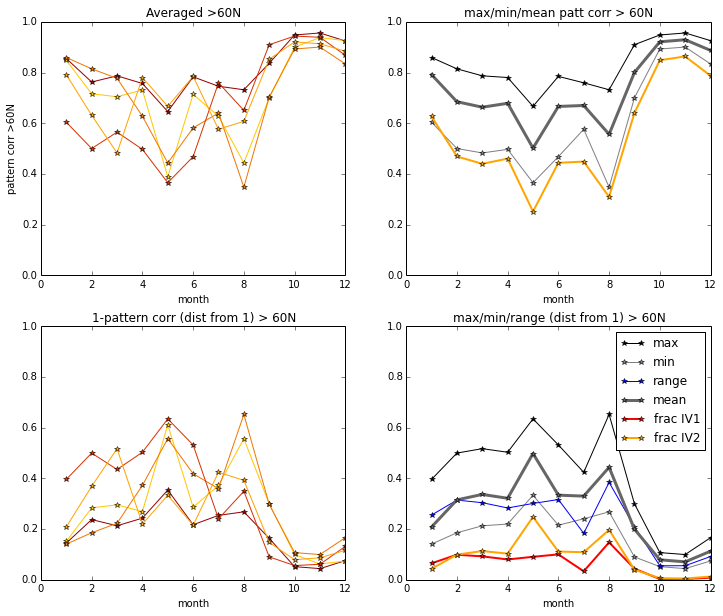

In [277]:
printtofile=False

fig,axs = plt.subplots(2,2)
fig.set_size_inches(12,10)
ax = axs[0,0]
for eii in range(1,ensnum+1):
    
    skey = 'r' + str(eii)
    ax.plot(xx,pcmeandict2[skey],color=colordict[skey],marker='*')
    
ax.set_ylabel('pattern corr >' + str(latlim) + 'N')
ax.set_xlabel('month')
ax.set_title('Averaged >' + str(latlim) + 'N')
ax.set_ylim(ylims)

ax = axs[1,0]
for eii in range(1,ensnum+1):
    
    skey = 'r' + str(eii)
    ax.plot(xx,1-np.abs(pcmeandict2[skey]),color=colordict[skey],marker='*')
    
ax.set_xlabel('month')
ax.set_title('1-pattern corr (dist from 1) > ' + str(latlim) + 'N')

ax.set_ylim((0,1))

# now want to plot the range
ax = axs[0,1]

ax.plot(xx,ensmax2,color='k',marker='*')
ax.plot(xx,ensmin2,color='0.5',marker='*')
#ax.plot(xx,ensrng2,color='b',marker='*')
ax.plot(xx,ensmean2,color='.4',marker='*',linewidth=3)
ax.plot(xx,ensmean2abs*ensmean2abs,color='orange',marker='*',linewidth=2)

ax.set_xlabel('month')
ax.set_title('max/min/mean patt corr > ' + str(latlim) + 'N')

ax.set_ylim(ylims)

# now want to plot the range
ax = axs[1,1]

ax.plot(xx,ensmaxi2,color='k',marker='*')
ax.plot(xx,ensmini2,color='0.5',marker='*')
ax.plot(xx,ensrngi2,color='b',marker='*')
ax.plot(xx,ensmeani2,color='.4',marker='*',linewidth=3)
ax.plot(xx,ensrngi2*ensrngi2,color='r',marker='*',linewidth=2)
ax.plot(xx,ensmeani2*ensmeani2,color='orange',marker='*',linewidth=2)

ax.set_xlabel('month')
ax.set_title('max/min/range (dist from 1) > ' + str(latlim) + 'N')

ax.set_ylim((0,1))
ax.legend(('max','min','range','mean','frac IV1','frac IV2'))

if printtofile:
    fig.savefig(fieldstr + 'pattcorr_nof' + str(latlim) + 'N_ensmems_cmpto_' + cmptype + '_seacyc.pdf')

In [278]:
#print ensrngi2*ensrngi2*100

#print ensmeani2*ensmeani2*100

#print ensmean2*ensmean2*100

# this should be akin to contribution of internal var:
print 100-ensmean2abs*ensmean2abs*100

print 'SEASONAL contrib from forcing:'
print ensmeanabssea2*ensmeanabssea2*100

0     37.325628
1     53.078802
2     56.002662
3     53.944844
4     74.793672
5     55.606579
6     55.107038
7     69.036119
8     35.927261
9     15.152300
10    13.648081
11    21.285815
dtype: float64
SEASONAL contrib from forcing:
0    86.494233
1    72.519012
2    50.085481
3    43.022658
dtype: float64


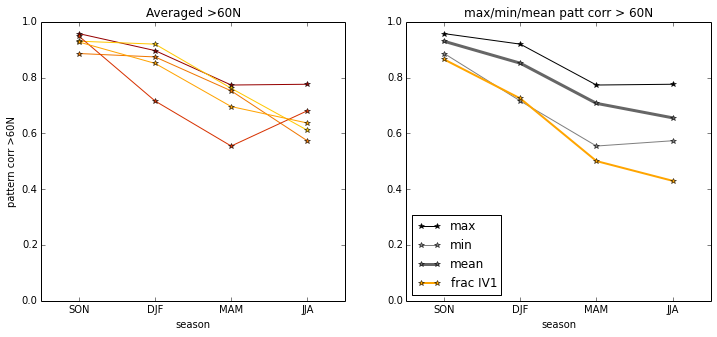

In [279]:
# plot SEASONAL data
printtofile=False

xxsea = np.arange(1,5)

fig,axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
ax = axs[0]
for eii in range(1,ensnum+1):
    
    skey = 'r' + str(eii)
    ax.plot(xxsea,pcseameandict2[skey],color=colordict[skey],marker='*')
    
ax.set_ylabel('pattern corr >' + str(latlim) + 'N')
ax.set_xlabel('season')
ax.set_xlim((.5,4.5))
ax.set_xticks(xxsea)
ax.set_xticklabels(seasons)
ax.set_title('Averaged >' + str(latlim) + 'N')
ax.set_ylim(ylims)

# now want to plot the range
ax = axs[1]

ax.plot(xxsea,ensmaxsea2,color='k',marker='*')
ax.plot(xxsea,ensminsea2,color='0.5',marker='*')
ax.plot(xxsea,ensmeansea2,color='.4',marker='*',linewidth=3)
ax.plot(xxsea,ensmeanabssea2*ensmeanabssea2,color='orange',marker='*',linewidth=2)
ax.set_xlim((.5,4.5))
ax.set_xticks(xxsea)
ax.set_xticklabels(seasons)
ax.set_xlabel('season')
ax.set_title('max/min/mean patt corr > ' + str(latlim) + 'N')
ax.set_ylim(ylims)
ax.legend(('max','min','mean','frac IV1'),'lower left')

if printtofile:
    fig.savefig(fieldstr + 'pattcorr_nof' + str(latlim) + 'N_ensmems_cmpto_' + cmptype + '_SEAS.pdf')

In [280]:
# Use diffdict 

latlim=60 # use weights already defined

keys = ('r1','r2','r3','r4','r5')

outterdict= dict.fromkeys(keys)

for skey1 in keys:
    
    outfld = diffdict[skey1]
    
    innerdict = dict.fromkeys(keys)
    
    for skey2 in keys:
        #print skey1 + ' compared to ' + skey2
        
        infld = diffdict[skey2]
        
        # for each month, compute pattern corr
        pc = np.zeros((12))
        for mii,mon in enumerate(con.get_mon()):
            tmp = np.squeeze(infld[mii,lat>latlim,...])
            tmpcmp = np.squeeze(outfld[mii,lat>latlim,...])
            pc[mii] = cutl.pattcorr(tmp.flatten()*weights2.flatten(),
                                    tmpcmp.flatten()*weights2.flatten())
            
        innerdict[skey2] = pc
        
    outterdict[skey1] = innerdict
  
pctable = pd.DataFrame(outterdict) # 5x5


# seasonal 
outterdictsea= dict.fromkeys(keys)

for skey1 in keys:
    
    outfld = seadiffdict[skey1]
    
    innerdictsea = dict.fromkeys(keys)
    
    for skey2 in keys:
        #print skey1 + ' compared to ' + skey2
        
        infld = seadiffdict[skey2]
        
        # for each season, compute pattern corr
        pcsea = np.zeros((4))
        for seaii,sea in enumerate(seasons):
            tmp = np.squeeze(infld[seaii,lat>latlim,...])
            tmpcmp = np.squeeze(outfld[seaii,lat>latlim,...])
            pcsea[seaii] = cutl.pattcorr(tmp.flatten()*weights2.flatten(),
                                    tmpcmp.flatten()*weights2.flatten())
            
        innerdictsea[skey2] = pcsea
        
    outterdictsea[skey1] = innerdictsea
  
pctable = pd.DataFrame(outterdict) # 5x5
pctablesea = pd.DataFrame(outterdictsea) # 5x5


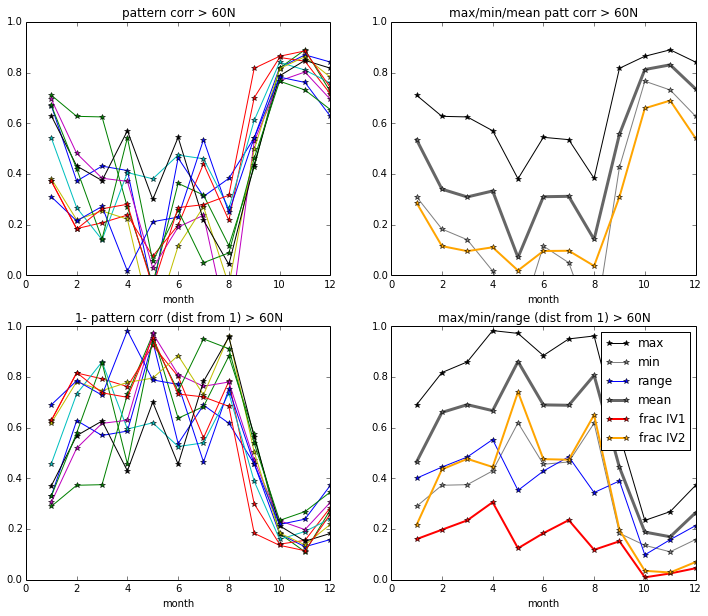

In [281]:
# seasonal cycle, each ens corr with each other
printtofile=False

fig,axs = plt.subplots(2,2)
fig.set_size_inches(12,10)
ax = axs[0,0]

pcstack = np.zeros((10,12)) # 10 combos x 12 months
stackii=0
for eii,skey1 in enumerate(keys):
        
    for ineii,skey2 in enumerate(keys[eii+1:len(keys)]):
        
        #print str(eii) + ': ' + skey1 + ', ' + str(ineii) + ': ' + skey2
        pc = pctable[skey1][skey2]
        ax.plot(xx,pc,marker='*')
        
        # also, stack the pc's so I can take max/min, etc
        pcstack[stackii] = pc
        stackii+=1
        
ax.set_ylim(ylims)
ax.set_title('pattern corr > ' + str(latlim) + 'N')
ax.set_xlabel('month')

ax = axs[1,0]

for eii,skey1 in enumerate(keys):
        
    for ineii,skey2 in enumerate(keys[eii+1:len(keys)]):
        
        #print str(eii) + ': ' + skey1 + ', ' + str(ineii) + ': ' + skey2
        pc = pctable[skey1][skey2]
        ax.plot(xx,1-np.abs(pc),marker='*')
        
ax.set_ylim((0,1))
ax.set_title('1- pattern corr (dist from 1) > ' + str(latlim) + 'N')
ax.set_xlabel('month')

ax = axs[0,1]

mx = np.max(pcstack,axis=0)
mn = np.min(pcstack,axis=0)
avg = np.mean(pcstack,axis=0)
# for the purposes of calculating the internal var
#   probably need to take average of the absolute value of corr
avgabs = np.mean(np.abs(pcstack),axis=0)
rng = mx-mn

ax.plot(xx,mx,color='k',marker='*')
ax.plot(xx,mn,color='0.5',marker='*')
#ax.plot(xx,rng,color='b',marker='*')
ax.plot(xx,avg,color='0.4',marker='*',linewidth=3)
ax.plot(xx,avgabs*avgabs,color='orange',marker='*',linewidth=2)

ax.set_title('max/min/mean patt corr > ' + str(latlim) + 'N')
ax.set_ylim(ylims)
ax.set_xlabel('month')


ax = axs[1,1]

pcstacki = 1-np.abs(pcstack)
mxi = np.max(pcstacki,axis=0)
mni = np.min(pcstacki,axis=0)
avgi = np.mean(pcstacki,axis=0)
rngi = mxi-mni

ax.plot(xx,mxi,color='k',marker='*')
ax.plot(xx,mni,color='0.5',marker='*')
ax.plot(xx,rngi,color='b',marker='*')
ax.plot(xx,avgi,color='0.4',marker='*',linewidth=3)

ax.plot(xx,rngi*rngi,color='r',marker='*',linewidth=2)
ax.plot(xx,avgi*avgi,color='orange',marker='*',linewidth=2)
ax.set_ylim((0,1))
ax.set_title('max/min/range (dist from 1) > ' + str(latlim) + 'N')
ax.legend(('max','min','range','mean','frac IV1','frac IV2'))
ax.set_xlabel('month')

if printtofile:
    fig.savefig(fieldstr + 'pattcorr_nof' + str(latlim) + 'N_ensmems_cmpto_ensmems_seacyc.pdf')

In [282]:
#print rngi*rngi*100

#print avgi*avgi*100

#print avg*avg*100

print 100-avgabs*avgabs*100



[ 71.35359873  88.43016475  90.42568812  88.90591733  98.0538854   90.368582
  90.27166287  96.24775379  69.00781643  34.0985309   31.05771578
  45.89292092]


----- st All the correlations: 
[[ 0.87151912  0.79668874  0.45971222  0.45364904]
 [ 0.85381505  0.78082035  0.4744495   0.24996844]
 [ 0.86812071  0.5087147   0.22660275  0.36092455]
 [ 0.8322624   0.64385469  0.3053215   0.44670778]
 [ 0.79055864  0.79828693  0.51202501  0.12272804]
 [ 0.85364442  0.58289157  0.30287222  0.07345571]
 [ 0.8429153   0.76776589  0.52101901  0.33895012]
 [ 0.75737515  0.41453286  0.17693276  0.5156182 ]
 [ 0.74102122  0.72059672  0.47356176  0.08650039]
 [ 0.91171984  0.57428093  0.41864587  0.24176194]]
Corr e/ ens with e/ other -- All the coefs of determination: 
[[ 0.75954557  0.63471294  0.21133532  0.20579745]
 [ 0.72900015  0.60968042  0.22510232  0.06248422]
 [ 0.75363357  0.25879065  0.05134881  0.13026653]
 [ 0.6926607   0.41454886  0.09322122  0.19954784]
 [ 0.62498296  0.63726202  0.26216961  0.01506217]
 [ 0.72870879  0.33976259  0.09173158  0.00539574]
 [ 0.71050621  0.58946446  0.27146081  0.11488718]
 [ 0.57361711  0.17183749  0.0313052  

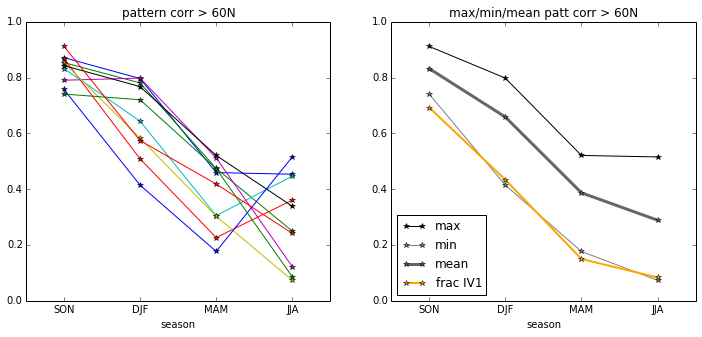

In [283]:
# plot SEASONAL mean DATA

printtofile=False

fig,axs = plt.subplots(1,2)
fig.set_size_inches(12,5)
ax = axs[0]

pcstacksea = np.zeros((10,4)) # 10 combos x 4 seasons
stackii=0
for eii,skey1 in enumerate(keys):
        
    for ineii,skey2 in enumerate(keys[eii+1:len(keys)]):
        
        #print str(eii) + ': ' + skey1 + ', ' + str(ineii) + ': ' + skey2
        pc = pctablesea[skey1][skey2]
        ax.plot(xxsea,pc,marker='*')
        
        # also, stack the pc's so I can take max/min, etc
        pcstacksea[stackii] = pc
        stackii+=1
        
ax.set_ylim(ylims)
ax.set_xlim((.5,4.5))
ax.set_xticks(xxsea)
ax.set_xticklabels(seasons)
ax.set_title('pattern corr > ' + str(latlim) + 'N')
ax.set_xlabel('season')


mxsea = np.max(pcstacksea,axis=0)
mnsea = np.min(pcstacksea,axis=0)
avgsea = np.mean(pcstacksea,axis=0)
# for the purposes of calculating the internal var
#   probably need to take average of the absolute value of corr
avgabssea = np.mean(np.abs(pcstacksea),axis=0)

# Maybe aren't supposed to average correlations?
#   see: http://www.statsoft.com/Textbook/Statistics-Glossary/P/button/p#Pearson%20Correlation
# Instead, square first, then average
# Should change any negative corrs to zero so they don't count in the percentage.
teststacksea=copy.copy(pcstacksea)
teststacksea[pcstacksea<0] = 0
pcstackseasq = np.power(teststacksea,2) # square the patt corr (the ones that are positive)
avgseasq = np.mean(pcstackseasq,axis=0) # average squared patt corr (coef of determination)
print '----- ' + fieldstr + ' All the correlations: ' 
print pcstacksea
print 'Corr e/ ens with e/ other -- All the coefs of determination: '
print pcstackseasq
print 'avg coef of determination: '
print avgseasq


ax = axs[1]
ax.plot(xxsea,mxsea,color='k',marker='*')
ax.plot(xxsea,mnsea,color='0.5',marker='*')
ax.plot(xxsea,avgsea,color='0.4',marker='*',linewidth=3)
ax.plot(xxsea,avgabssea*avgabssea,color='orange',marker='*',linewidth=2)
ax.set_title('max/min/mean patt corr > ' + str(latlim) + 'N')
ax.set_ylim(ylims)
ax.set_xlim((.5,4.5))
ax.set_xticks(xxsea)
ax.set_xticklabels(seasons)
ax.set_xlabel('season')
ax.legend(('max','min','mean','frac IV1'),'lower left')

if printtofile:
    fig.savefig(fieldstr + 'pattcorr_nof' + str(latlim) + 'N_ensmems_cmpto_ensmems_SEAS.pdf')
    
#print 'SEASONAL:'
#print avgabssea*avgabssea*100


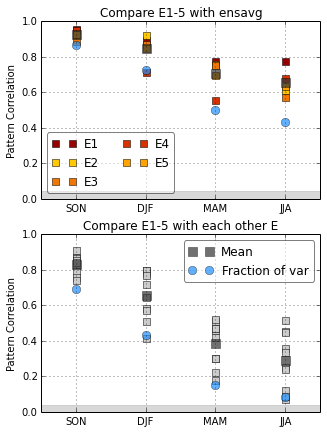

In [284]:
printtofile=True

fig,axs = plt.subplots(2,1)
fig.set_size_inches(5,7) # more squat

ax = axs[0]

legtpl=()

# this is for comp w/ mean BC
for eii in range(1,ensnum+1):
    
    skey = 'r' + str(eii)
    ax.plot(xxsea,pcseameandict2[skey],color=colordict[skey],marker='s',linestyle='none',markersize=7)
    legtpl = legtpl + ('E' + str(eii),)
    
ax.plot(xxsea,ensmeansea2,color='.2',marker='s',linestyle='none',markersize=9,alpha=.7)
ax.plot(xxsea,ensmeanabssea2*ensmeanabssea2,color=ccm.get_linecolor('dodgerblue'),marker='o',linestyle='none',markersize=8,alpha=.7) 
# @@@@ not sure I actually want the absolute value after all.....see below

ax.set_ylabel('Pattern Correlation')
#ax.set_xlabel('season')
ax.axhspan(-1*rmin,rmin,color='.7',alpha=.5)
ax.set_xlim((.5,4.5))
ax.set_xticks(xxsea)
ax.set_xticklabels(seasons)
ax.set_title('Compare E1-5 with ' + cmptype)
ax.set_ylim(ylims)
ax.grid(True)
#ax.legend(legtpl,'lower left', ncol=2)
leg = ax.legend(legtpl,loc='best', fancybox=True,ncol=2)
leg.get_frame().set_alpha(0.5)

ax = axs[1]
# this is for comp w/ e/ ens member
for eii,skey1 in enumerate(keys):
        
    for ineii,skey2 in enumerate(keys[eii+1:len(keys)]):
        
        #print str(eii) + ': ' + skey1 + ', ' + str(ineii) + ': ' + skey2
        pc = pctablesea[skey1][skey2]
        ax.plot(xxsea,pc,marker='s',linestyle='none',markersize=7,color='.8')

avgp, = ax.plot(xxsea,avgsea,color='0.2',marker='s',linestyle='none',markersize=9,alpha=.7)      
fracvarp, = ax.plot(xxsea,avgabssea*avgabssea,color=ccm.get_linecolor('dodgerblue'),marker='o',linestyle='none',markersize=8,alpha=.7)
# @@@@ not sure I actually want the absolute value after all.....see below
ax.axhspan(-1*rmin,rmin,color='.7',alpha=.5)
ax.set_ylim(ylims)
ax.set_xlim((.5,4.5))
ax.set_xticks(xxsea)
ax.set_xticklabels(seasons)
ax.set_ylabel('Pattern Correlation')
ax.set_title('Compare E1-5 with each other E')
leg = ax.legend((avgp,fracvarp),('Mean','Fraction of var'),loc='best', fancybox=True)
leg.get_frame().set_alpha(0.5)
#ax.legend((avgp,fracvarp),('Mean','Fraction of var'),'lower left')
#ax.set_xlabel('season')
ax.grid(True)

if printtofile:
    fig.savefig(fieldstr + 'pattcorr_nof' + str(latlim) + 'N_bothcmps_' + cmptype + 'SEAS.pdf')
    


In [285]:
ensmeansea2
print xxsea
xboxmin=xxsea-.1
xboxmax=xxsea+.1
print xboxmin[0]
print xboxmax[0]



[1 2 3 4]
0.9
1.1


[ 0.24931507  0.24657534  0.25205479  0.25205479]
0.633422861685
0.785556416635
0.540382752416
0.352550028598


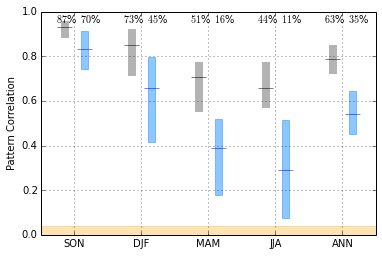

In [286]:
# Change to bars spanning the range, instead of dots 8/25
#  Also, supposedly can't average correlations 
#  (http://www.statsoft.com/Textbook/Statistics-Glossary/P/button/p#Pearson%20Correlation).
#     
#  Instead, plot the r^2 (coefficient of determination) and the mean of that.
#  

printtofile=True


# add annual mean
annwgts = np.array((91,90,92,92))/365.
print annwgts

fig,axs = plt.subplots(1,1)
fig.set_size_inches(6,4) # more squat

ax = axs #[0]

legtpl=()

wi=0.1 # width of bar
incr=0.3 # how much to shift in b/w the 2 sets of data
xxsea2=np.arange(1,6)
xboxmin=xxsea2-.2

ax.axhspan(-1*rmin,rmin,color='orange',alpha=.3) # shade where corr is NOT significant

fillcol='0.7'
fillcol2=ccm.get_linecolor('dodgerblue')
for boxii in range(0,4): # loop through seasons
    # shaded bars/boxes
    ax.fill_between((xboxmin[boxii],xboxmin[boxii]+wi),ensminsea2[boxii],ensmaxsea2[boxii],color=fillcol)
    ax.fill_between((xboxmin[boxii]+incr,xboxmin[boxii]+incr+wi),mnsea[boxii], mxsea[boxii],color=fillcol2, alpha=.5)
    
    # markers
    ax.plot(xboxmin[boxii]+wi/2.,ensmeansea2[boxii],color='k',marker='_',linestyle='none',markersize=15)#,alpha=.9)
    ax.plot(xboxmin[boxii]+wi/2.+incr,avgsea[boxii],color='b',marker='_',linestyle='none',markersize=15)#,alpha=.7)   
    
    # mean values (text)
    #val = '$%.0f$'%(ensmeansea2[boxii]*ensmeansea2[boxii]*100)
    val = '$%.0f$'%(ensmeansea2sq[boxii]*100)# @@ square the corrs before taking mean
    #print val
    #print ensmeansea2[boxii]*ensmeansea2[boxii]*100
    ax.annotate(val+'%', xy=(xboxmin[boxii]-.07, .95),  xycoords='data')
    #val = '$%.0f$'%(avgsea[boxii]*avgsea[boxii]*100)
    val = '$%.0f$'%(avgseasq[boxii]*100) # @@ square the corrs before taking mean
    #print val
    #print avgsea[boxii]*avgsea[boxii]*100
    ax.annotate(val+'%', xy=(xboxmin[boxii]+wi/2.+incr -.07, .95),  xycoords='data')

boxii=boxii+1
# @@ don't use absolute value to calc mean and hence r^2. 
# Because these are pattern corrs b/w the same variables, anything <0 is basically zero correlation.
#ax.plot(xxsea,ensmeanabssea2*ensmeanabssea2,color=ccm.get_linecolor('dodgerblue'),
#    marker='o',linestyle='none',markersize=8,alpha=.7)   

# add annual mean
# w/ mean BC
# pcstackseasq is 10x4 
annwgtst = np.tile(annwgts,(5,1)) # tile

# pcseameandf2sq is 5x4
ann2sq = np.average(np.transpose(np.array(pcseameandf2sq),(1,0)),weights=annwgtst,axis=1) # ann mean squared per patt corr
annensmean2sq = np.mean(ann2sq)
print annensmean2sq
#
ann2 = np.average(np.transpose(np.array(pcseameandf2),(1,0)),weights=annwgtst,axis=1) # ann mean per patt corr
ann2max = np.max(ann2)
ann2min = np.min(ann2)
annensmean2 = np.mean(ann2)
print annensmean2

# each ens w/ each other
# pcstackseasq is 10x4 
annwgtst = np.tile(annwgts,(10,1)) # tile
ann = np.average(pcstacksea,weights=annwgts,axis=1) # ann mean per patt corr
annmax = np.max(ann)
annmin = np.min(ann)
avgann = np.mean(ann)
print avgann
#
annsq = np.average(pcstackseasq,weights=annwgts,axis=1) # ann mean per patt corr
avgannsq = np.mean(annsq)
print avgannsq

# plot annual mean markers
ax.fill_between((xboxmin[boxii],xboxmin[boxii]+wi),ann2min,ann2max,color=fillcol)
ax.fill_between((xboxmin[boxii]+incr,xboxmin[boxii]+incr+wi),annmin,annmax,color=fillcol2,alpha=.5)

ax.plot(xboxmin[boxii]+wi/2.,annensmean2,color='k',marker='_',linestyle='none',markersize=15)#,alpha=.9)
ax.plot(xboxmin[boxii]+wi/2.+incr,avgann,color='b',marker='_',linestyle='none',markersize=15)#,alpha=.9)

val = '$%.0f$'%(annensmean2sq*100)# @@ square the corrs before taking mean
ax.annotate(val+'%', xy=(xboxmin[boxii]-.07, .95),  xycoords='data')

val = '$%.0f$'%(avgannsq*100) # @@ square the corrs before taking mean
ax.annotate(val+'%', xy=(xboxmin[boxii]+wi/2.+incr -.07, .95),  xycoords='data')


#ax.plot(xxsea[3]+.8,annensmean2,color=fillcol,marker='s',markersize=6) # @@ add each ann mean (max/min)
#ax.plot((xxsea[3]+.8,xxsea[3]+.8),(ann2min,ann2max),color=fillcol)
#ax.plot(xxsea[3]+.9,avgann,color=fillcol2,marker='s',markersize=6) # @@ add each ann mean (max/min)
#ax.plot((xxsea[3]+.9,xxsea[3]+.9),(annmin,annmax),color=fillcol2)

ax.set_ylabel('Pattern Correlation')
#ax.set_xlabel('season')
ax.set_xlim((.5,5.5))
ax.set_xticks(xxsea2)
ax.set_xticklabels((seasons)+('ANN',))
#ax.set_title('Compare E1-5 with CAN')
ax.set_ylim((0,1))
ax.grid(True)


if printtofile:
    fig.savefig(fieldstr + 'pattcorr_nof' + str(latlim) + 'N_bothcmps_' + cmptype + 'BARS_SEAS_sqfirst.pdf')
    


In [287]:
annwgts = np.array((91,90,92,92))/365.

annwgtst = np.tile(annwgts,(5,1)) # tile
print 'annwgtst.shape ' + str(annwgtst.shape)
#print pcseameandf2sq

#print np.transpose(np.array(pcseameandf2sq),(1,0)).shape

# pcseameandf2sq is 5x4
ann2sq = np.average(np.transpose(np.array(pcseameandf2sq),(1,0)),weights=annwgtst,axis=1)
print ann2sq
annensmean2sq = np.mean(ann2sq)
print annensmean2sq



print pcstacksea.shape
annwgts = np.array((91,90,92,92))/365.

annwgtst = np.tile(annwgts,(10,1)) # tile
print 'annwgtst.shape ' + str(annwgtst.shape)
annavgsq = np.average(pcstacksea,weights=annwgts,axis=1)
print annavgsq


annwgtst.shape (5, 4)
[ 0.72951461  0.66500228  0.60990713  0.54512667  0.61756362]
0.633422861685
(10, 4)
annwgtst.shape (10, 4)
[ 0.64394373  0.58799302  0.48996115  0.55580683  0.5539286   0.45140837
  0.61622297  0.46559941  0.50359549  0.53536796]


In [288]:

latlim=60

# baseline pattern to compare to
cmpcasenamep='kem1pert2ens' # else, 'kemhadpert', 'kemnsidcpert'
cmpcasenamec='kemctl1ens'
#cmptype = 'ensavg' #cmptype = 'meanBC'

bcasenamep='kem1pert2'
bcasenamec='kemctl1'

timesel = '0002-01-01,0121-12-31'
seasons = ('SON','DJF','MAM','JJA')

# get baseline to which to compare
fnamecc = basepath + cmpcasenamec + subdir + cmpcasenamec + '_' + field + '_001-121_ts.nc'
fnamepc = basepath + cmpcasenamep + subdir + cmpcasenamep + '_' + field + '_001-121_ts.nc'
fldcc = cnc.getNCvar(fnamecc,ncfield,timesel=timesel)*conv
fldpc = cnc.getNCvar(fnamepc,ncfield,timesel=timesel)*conv
flddc = fldpc-fldcc


# seasonal baseline to which to compare
fldccsea = np.zeros((4,len(lat),len(lon)))
fldpcsea = np.zeros((4,len(lat),len(lon)))
flddcsea = np.zeros((4,len(lat),len(lon)))
              
for seaii,sea in enumerate(seasons):
    fldccsea[seaii,...] = np.mean(cnc.getNCvar(fnamecc,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
    fldpcsea[seaii,...] = np.mean(cnc.getNCvar(fnamepc,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
    flddcsea[seaii,...] = fldpcsea[seaii,...]-fldccsea[seaii,...]


diffdict = {} # fldp-fldc 
pcmeandict = {} # fldp-fldc pattern corr compared to mean BC
pchaddict = {} # fldp-fldc pattern corr compared to hadisst
seadiffdict = {} # same as above but seasonal mean
pcseameandict = {}
pcsea2meandict = {}
pcsea2pvalmeandict = {}

# generate weights for the pattern corr
areas = cutl.calc_cellareas(lat,lon)
areas = areas[lat>latlim,:]
weights = areas / np.sum(np.sum(areas,axis=1),axis=0)

if 1:   # cheating with the indentation
    casenamec = bcasenamec 
    casenamep = bcasenamep
    fnamec = basepath + casenamec+ subdir + casenamec + '_' + field + '_001-121_ts.nc'
    fnamep = basepath + casenamep+ subdir + casenamep + '_' + field + '_001-121_ts.nc'

    # monthly calc
    fldc = cnc.getNCvar(fnamec,ncfield,timesel=timesel)*conv
    fldp = cnc.getNCvar(fnamep,ncfield,timesel=timesel)*conv
    fldd = fldp-fldc
    
    # take the pattern correlation
    flddclimo,flddstd = cutl.climatologize(fldd) # climo first (don't need to do for BCs technically)
    flddcclimo,flddcstd = cutl.climatologize(flddc) # climo first
        
    # for each month, compute pattern corr
    pc = np.zeros((12))
    for mii,mon in enumerate(con.get_mon()):
        tmp = np.squeeze(flddclimo[mii,lat>latlim,...])
        tmpcmp = np.squeeze(flddcclimo[mii,lat>latlim,...])
        pc[mii] = cutl.pattcorr(tmp.flatten()*weights.flatten(),tmpcmp.flatten()*weights.flatten())
        
    # seasonal calc    
    fldcsea = np.zeros((4,len(lat),len(lon)))
    fldpsea = np.zeros((4,len(lat),len(lon)))
    flddsea = np.zeros((4,len(lat),len(lon)))
    for seaii,sea in enumerate(seasons):
        fldcsea[seaii,...] = np.mean(cnc.getNCvar(fnamec,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
        fldpsea[seaii,...] = np.mean(cnc.getNCvar(fnamep,ncfield,timesel=timesel,seas=sea)*conv,axis=0)
        flddsea[seaii,...] = fldpsea[seaii,...]-fldcsea[seaii,...]
        
    
    seadiffdict[skey] = flddsea
    
    pcsea = np.zeros((4))
    pcsea2 = np.zeros((4)) # test pattcorr_pearson() @@
    pcsea2pval = np.zeros((4)) # test pattcorr_pearson()
    for seaii,sea in enumerate(seasons):
        tmp = np.squeeze(flddsea[seaii,lat>latlim,...])
        tmpcmp = np.squeeze(flddcsea[seaii,lat>latlim,...])
        pcsea[seaii] = cutl.pattcorr(tmp.flatten()*weights.flatten(),
                                     tmpcmp.flatten()*weights.flatten())
        pcsea2[seaii],pcsea2pval[seaii] = cutl.pattcorr_pearson(tmp.flatten()*weights.flatten(),
                                                                tmpcmp.flatten()*weights.flatten())
        
    print 'corr: ' + str(pcsea2)
    testpcsea2=copy.copy(pcsea2)
    testpcsea2[pcsea2<0]=0
    print '% var: ' + str(testpcsea2*testpcsea2*100)
    print field + ' and ' + fieldstr
    

corr: [ 0.97710555  0.96751859  0.83486189  0.63073631]
% var: [ 95.47352642  93.60922299  69.69943824  39.78282946]
st and st
